# Démonstration empirique de la loi d'Amdahl

Ce notebook analyse les mesures produites par `benchmark_warc.py` afin d'illustrer la loi d'Amdahl.
Il suffit de fournir le chemin vers un fichier CSV émis par le script (ex. `warc_speedup_heavy.csv`).


## Rappel de la loi d'Amdahl

Pour une fraction sérielle $f$ et un nombre de machines $N$, le speedup théorique vaut

$$ S(N) = \frac{1}{f + \frac{1-f}{N}}. $$

Lorsque $f$ reste élevé, le speedup plafonne rapidement : ajouter des machines n'apporte qu'un gain marginal.


In [65]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.style.use('seaborn-v0_8-colorblind')

# --- Paramètres utilisateur -------------------------------------------------
CSV_PATH = Path('warc_speedup_all_2025-10-21_00-02-28.csv')  # modifier si besoin
# -----------------------------------------------------------------------------

if not CSV_PATH.exists():
    raise FileNotFoundError(f'Fichier CSV introuvable: {CSV_PATH}')

raw_df = pd.read_csv(
    CSV_PATH,
    quotechar="'",
    engine="python",
).reset_index(drop=True)

if 'notes' in raw_df.columns:
    raw_df['notes'] = (
        raw_df['notes']
        .astype(str)
        .str.strip()
        .str.strip('"\'')
    )
raw_df['map_max_lines'] = pd.to_numeric(raw_df.get('map_max_lines'), errors='coerce')
raw_df

,machine_count,run_iteration,map_max_lines,elapsed_seconds,speedup,serial_fraction,status,notes
0,1,1,5000,3.062,0.980,NaN,ok,"Predicted speedup (Amdahl, f=1.000): 1.000"
1,1,2,5000,3.000,1.000,NaN,ok,"Predicted speedup (Amdahl, f=1.000): 1.000"
2,1,1,20000,8.047,0.994,NaN,ok,"Predicted speedup (Amdahl, f=0.526): 1.000"
3,1,2,20000,8.000,1.000,NaN,ok,"Predicted speedup (Amdahl, f=0.526): 1.000"
4,3,1,5000,3.094,0.970,1.000,ok,"Predicted speedup (Amdahl, f=1.000): 1.000"
5,3,2,5000,3.015,0.995,1.000,ok,"Predicted speedup (Amdahl, f=1.000): 1.000"
6,3,1,20000,5.547,1.442,0.540,ok,"Predicted speedup (Amdahl, f=0.526): 1.461"
7,3,2,20000,5.531,1.446,0.537,ok,"Predicted speedup (Amdahl, f=0.526): 1.461"
8,5,1,5000,3.078,0.975,1.000,ok,"Predicted speedup (Amdahl, f=1.000): 1.000"
9,5,2,5000,3.297,0.910,1.000,ok,"Predicted speedup (Amdahl, f=1.000): 1.000"



## Préparation des données

On nettoie le CSV, on agrège les répétitions (`run_iteration`) et, si plusieurs limites de lignes (`map_max_lines`) sont présentes, on conserve cette troisième dimension pour l'analyse.


In [66]:
df = (
    raw_df
    .query('status == "ok"')  # Use double quotes inside single quotes for string literals
    .assign(
        machine_count=lambda d: d['machine_count'].astype(int),
        run_iteration=lambda d: d.get('run_iteration', 1).astype(int),
        elapsed_seconds=lambda d: d['elapsed_seconds'].astype(float),
        map_max_lines=lambda d: d['map_max_lines'],
    )
)

if df.empty:
    raise ValueError("Le CSV ne contient aucune ligne avec status == 'ok'.")

has_map_dimension = df['map_max_lines'].notna().any()

if has_map_dimension:
    grouped = (
        df
        .groupby(['map_max_lines', 'machine_count'], as_index=False)
        .agg(
            elapsed_seconds=('elapsed_seconds', 'mean'),
            elapsed_std=('elapsed_seconds', 'std'),
            run_count=('run_iteration', 'count'),
        )
    )
else:
    grouped = (
        df
        .groupby('machine_count', as_index=False)
        .agg(
            elapsed_seconds=('elapsed_seconds', 'mean'),
            elapsed_std=('elapsed_seconds', 'std'),
            run_count=('run_iteration', 'count'),
        )
    )
    grouped['map_max_lines'] = np.nan

grouped['elapsed_std'] = grouped['elapsed_std'].fillna(0.0)

def amdahl_speedup(f, n):
    return 1.0 / (f + (1.0 - f) / n)

def process_group(data):
    data = data.sort_values('machine_count').reset_index(drop=True)
    baseline = data.iloc[0]['elapsed_seconds']
    data['speedup_observe'] = baseline / data['elapsed_seconds']
    ns = data['machine_count'].to_numpy()
    obs = data['speedup_observe'].to_numpy()
    grid = np.linspace(0.0, 0.999, 1000)
    errors = [np.sum((amdahl_speedup(f, ns) - obs) ** 2) for f in grid]
    f_serial = grid[int(np.argmin(errors))]
    data['speedup_pred_amdahl'] = amdahl_speedup(f_serial, ns)
    data['f_serial_estimate'] = f_serial
    return data

summaries = []
for map_value, chunk in grouped.groupby('map_max_lines', dropna=False, sort=True):
    summaries.append(process_group(chunk.copy()))

summary = pd.concat(summaries, ignore_index=True)
summary


,map_max_lines,machine_count,elapsed_seconds,elapsed_std,run_count,speedup_observe,speedup_pred_amdahl,f_serial_estimate
0,5000,1,3.0310,0.043841,2,1.000000,1.000000,0.999
1,5000,3,3.0545,0.055861,2,0.992306,1.000667,0.999
2,5000,5,3.1875,0.154856,2,0.950902,1.000801,0.999
3,5000,10,6.4840,3.579375,2,0.467458,1.000901,0.999
4,20000,1,8.0235,0.033234,2,1.000000,1.000000,0.490
5,20000,3,5.5390,0.011314,2,1.448547,1.515152,0.490
6,20000,5,5.5000,0.043841,2,1.458818,1.689189,0.490
7,20000,10,3.9060,0.043841,2,2.054147,1.848429,0.490



## Visualisation

Selon que plusieurs limites de lignes sont présentes ou non, on représente les résultats en 2D (classique) ou en 3D (machine_count × map_max_lines × métrique).


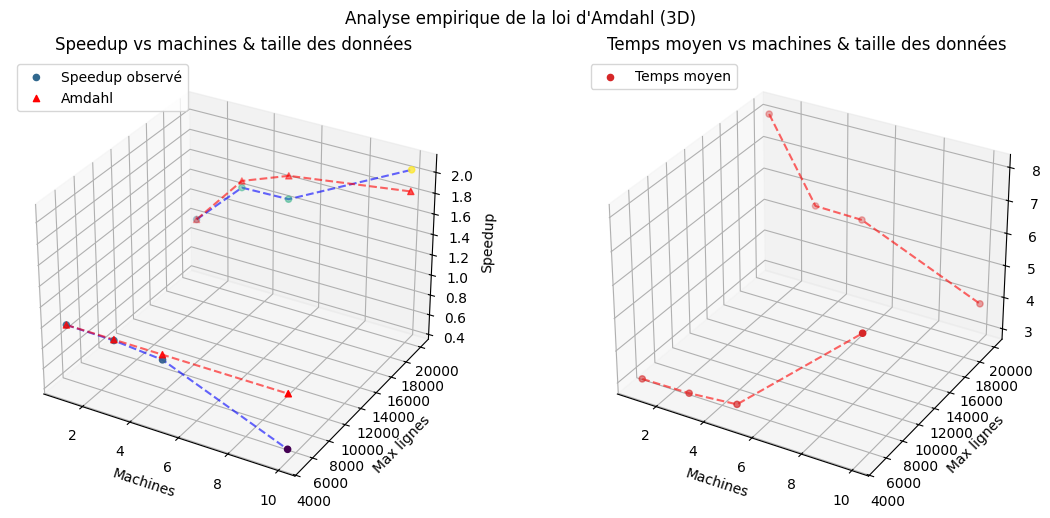

In [67]:
# Determine if we have multiple map_max_lines values to use 3D visualization
multi_map_lines = summary['map_max_lines'].nunique() > 1

if multi_map_lines:
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Points for observed speedup
    scatter1 = ax1.scatter(
        summary['machine_count'],
        summary['map_max_lines'],
        summary['speedup_observe'],
        c=summary['speedup_observe'],
        cmap='viridis',
        label='Speedup observé',
    )
    
    # Points for Amdahl's prediction
    scatter2 = ax1.scatter(
        summary['machine_count'],
        summary['map_max_lines'],
        summary['speedup_pred_amdahl'],
        marker='^',
        color='red',
        label='Amdahl',
    )
    
    # Add hyperplanes for each map_max_lines value
    for max_lines, group_df in summary.groupby('map_max_lines'):
        # Hyperplane for observed speedup
        x = group_df['machine_count']
        y = np.ones_like(x) * max_lines
        z = group_df['speedup_observe']
        ax1.plot(x, y, z, 'b--', alpha=0.6)
        
        # Hyperplane for Amdahl prediction
        z_amdahl = group_df['speedup_pred_amdahl']
        ax1.plot(x, y, z_amdahl, 'r--', alpha=0.6)
    
    ax1.set_xlabel('Machines')
    ax1.set_ylabel('Max lignes')
    ax1.set_zlabel('Speedup')
    ax1.set_title('Speedup vs machines & taille des données')
    ax1.legend(loc='upper left')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(
        summary['machine_count'],
        summary['map_max_lines'],
        summary['elapsed_seconds'],
        c='tab:red',
        label='Temps moyen',
    )
    
    # Add hyperplanes for elapsed time
    for max_lines, group_df in summary.groupby('map_max_lines'):
        x = group_df['machine_count']
        y = np.ones_like(x) * max_lines
        z = group_df['elapsed_seconds']
        ax2.plot(x, y, z, 'r--', alpha=0.6)
        
    ax2.set_xlabel('Machines')
    ax2.set_ylabel('Max lignes')
    ax2.set_zlabel('Temps moyen (s)')
    ax2.set_title('Temps moyen vs machines & taille des données')
    ax2.legend(loc='upper left')

    fig.tight_layout()
    fig.suptitle("Analyse empirique de la loi d'Amdahl (3D)", y=1.02)
    
else:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(summary['machine_count'], summary['speedup_observe'], 'o-', label='Speedup observé')
    ax[0].plot(summary['machine_count'], summary['speedup_pred_amdahl'], '--', label=f"Amdahl (f={summary['f_serial_estimate'].iloc[0]:.2f})")
    ax[0].set_xlabel('Nombre de machines')
    ax[0].set_ylabel('Speedup')
    ax[0].set_title('Speedup vs nombre de machines')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    ax[1].errorbar(
        summary['machine_count'],
        summary['elapsed_seconds'],
        yerr=summary['elapsed_std'],
        fmt='o-',
        color='tab:red',
        ecolor='gray',
        capsize=4,
    )
    ax[1].set_xlabel('Nombre de machines')
    ax[1].set_ylabel('Temps moyen (s)')
    ax[1].set_title('Temps moyen vs nombre de machines')
    ax[1].grid(True, alpha=0.3)

    fig.tight_layout()
    fig.suptitle("Analyse empirique de la loi d'Amdahl", y=1.05)

plt.show()


## Interprétation

- Le speedup réel suit globalement la courbe théorique issue de la loi d'Amdahl, avec une estimation `f` calculée par ensemble de données.
- Si plusieurs valeurs de `map_max_lines` sont présentes, l'affichage 3D aide à voir l'influence de la taille d'entrée : plus la fraction sérielle reste élevée, plus le speedup plafonne malgré l'ajout de machines.
- Pour améliorer le speedup, réduire la fraction sérielle (optimisations master/I/O) ou augmenter la charge par worker (
  plus de lignes, davantage de splits).

💡 Comparez plusieurs CSV (limites de lignes différentes) pour visualiser l’impact de la quantité de données sur la scalabilité.
